<a href="https://colab.research.google.com/github/xmpuspus/Lectures/blob/master/notebooks/Solving_PDEs_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving Partial Diffirential Equations with Neural Networks

Limitations (as of May 7, 2019):

1. The neural network can only solve 1-dimensional linear advection equations of the form $\frac{\partial u}{\partial t} + a\frac{\partial u}{\partial x} = 0$
2. The network has only been trained on PDEs with periodic boundaries. Generalization to non-periodic boundaries is not guaranteed.

Preliminary Results (as of May 7, 2019):

1. The neural network performs just as well as the Lax-Friedrich scheme.
2. Even a 1-layer, non-biased, and non-activated neural net already performs well. This suggests that a simple multiple linear regression should be enough to solve 1D linear advection equations.

Suggestions for further research:

1. Train on more forms of PDEs (i.e. on higher order and/or higher dimensional PDEs).
2. Train on functions with fixed or other non-periodic boundary conditions.
3. The `mean_squared_error` loss function performs so much worse than the `mean_absolute_error`. Figure out which loss function is the best. 
4. Try to minimize the `total variation` of the solution ($TV(u) = \sum|u_j - u_{j-1}|$). One way to do this is by explicitly adding it as a loss. Try to use the fact that if $C \geq 0, D \geq 0, 0 \leq C+D \leq 1$ when a scheme is written as $u_j^{n+1} = u_j^n - C(u_{j+1}^n - u_j^n) + D(u_j^n - u_{j-1}^n)$, then the scheme is guaranteed to be stable and non-oscillatory.

## Download and import the necessary libraries

In [0]:
%%capture
!pip3 install tensorflow-gpu==2.0.0-alpha numpy matplotlib pandas

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow.keras as tfk

## Prepare the data

First, let's initialize the constants.

In [0]:
left_x = -np.pi
right_x = np.pi
nx = 100
dx = (right_x - left_x) / nx

left_t = 0
right_t = 1
nt = 100
dt = (right_t - left_t) / nt

Then, let's define the functions we're going to approximate

In [0]:
EPS = 1e-9

def f(x, t, a=1):
  return np.sin(x - a*t)

def g(x, t, a=1):
  return np.sin(x - a*t) / (x - a*t + EPS)

def h(x, t, a=1):
  return np.sin(2*(x - a*t)) + np.cos(x - a*t)

In [0]:
x = np.linspace(left_x, right_x, nx)

u = []
v = []
w = []
for t in range(nt):
  u.append(f(x, dt*t))
  v.append(g(x, dt*t))
  w.append(h(x, dt*t))
u = np.asarray(u).T
v = np.asarray(v).T
w = np.asarray(w).T

In [0]:
u.shape, v.shape, w.shape

((100, 100), (100, 100), (100, 100))

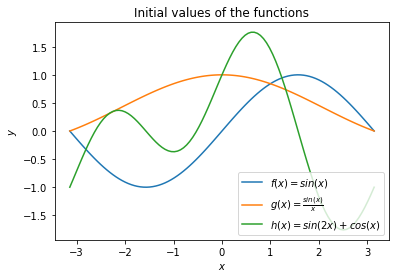

In [0]:
plt.plot(x, u[:,0], label="$f(x) = sin(x)$")
plt.plot(x, v[:,0], label="$g(x) = \\frac{sin(x)}{x}$")
plt.plot(x, w[:,0], label="$h(x) = sin(2x) + cos(x)$")
plt.title("Initial values of the functions")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Then, let's generate features and labels that we're going to use to train our neural network

In [0]:
def generate_features(u):
  features = []
  features.append(np.array([u[-2], u[0], u[1]]))
  for j in range(1, nx-1):
    features.append(u[j-1:j+2])
  features.append(np.array([u[-2], u[-1], u[1]]))
  return features

In [0]:
x_raw = []
y_raw = []

for n in range(nt-1):
  x_raw.extend(generate_features(u[:,n]))
  y_raw.extend(u[:,n+1].tolist())
    
for n in range(nt-1):
  x_raw.extend(generate_features(v[:,n]))
  y_raw.extend(v[:,n+1].tolist())
    
for n in range(nt-1):
  x_raw.extend(generate_features(v[:,n]))
  y_raw.extend(w[:,n+1].tolist())
  
x_raw = np.asarray(x_raw)
y_raw = np.asarray(y_raw)

In [0]:
print(x_raw.shape, y_raw.shape)

(29700, 3) (29700,)


## The model

First, let's define the library,

In [0]:
def build_model(layers=1, n_hidden=3):
  model = tfk.Sequential()
  model.add(tfk.layers.Input((3,)))
  for l in range(1, layers):
    model.add(tfk.layers.Dense(n_hidden, kernel_regularizer=tfk.regularizers.l1(0.01), use_bias=False))
  model.add(tfk.layers.Dense(1, kernel_regularizer=tfk.regularizers.l1(0.01), use_bias=False))

  model.compile(loss='mean_absolute_error',
                optimizer='adam',
                metrics=['mean_squared_error'])
  
  return model

create an instance of it,

In [0]:
nn_solver = build_model()

inspect it,

In [0]:
nn_solver.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


then train it.

In [0]:
class PrintDot(tfk.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')    

early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
history = nn_solver.fit(
  x_raw, y_raw,
  epochs=100, validation_split=0.2, verbose=0, callbacks=[PrintDot(), early_stop])


...........

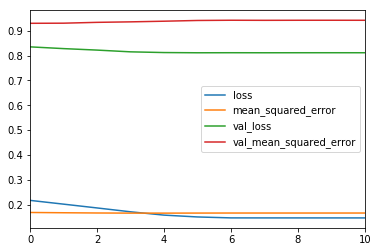

In [0]:
pd.DataFrame(history.history).plot()

In [0]:
nn_solver.get_weights()

[array([[0.23355539],
        [0.69126856],
        [0.07558292]], dtype=float32)]

## Tests

### Tests on arbitrary points in time

#### Seen datasets

Let's predict $f(x, \Delta t)$ from $f(x, 0)$

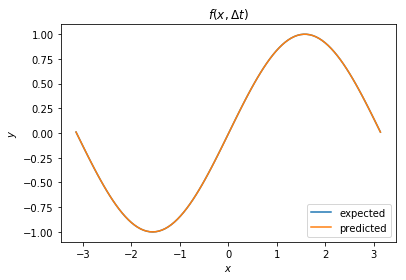

In [0]:
y_expected = f(x, dt*1)
y_predicted = nn_solver.predict([generate_features(u[:,0])])

plt.plot(x, y_expected, label="expected")
plt.plot(x, y_predicted, label="predicted")
plt.title("$f(x, \Delta t)$")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Then let's predict $g(x, 50*\Delta t)$ from $g(x, 49*\Delta t)$

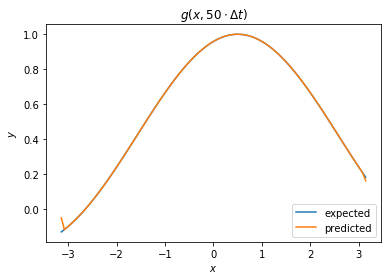

In [0]:
y_expected = g(x, dt*50)
y_predicted = nn_solver.predict([generate_features(v[:,49])])

plt.plot(x, y_expected, label="expected")
plt.plot(x, y_predicted, label="predicted")
plt.title("$g(x, 50\cdot\Delta t)$")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

#### Unseen dataset

In [0]:
def test_func(x, t, a=1):
  return np.sin(x - a*t) + np.cos(3*(x - a*t))

Note that the neural network hasn't seen this during training. Let's try to predict $h(x, 100*\Delta t)$ from $h(x, 99*\Delta t)$

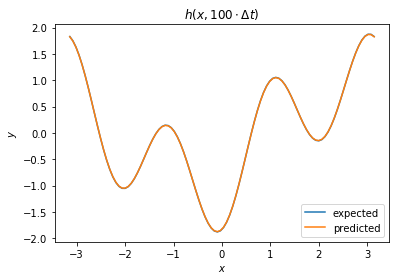

In [0]:
y_expected = test_func(x, dt*100)
y_predicted = nn_solver.predict([generate_features(test_func(x, dt*99))])

plt.plot(x, y_expected, label="expected")
plt.plot(x, y_predicted, label="predicted")
plt.title("$h(x, 100\cdot\Delta t)$")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Yey! Our neural network generalizes to unseen datasets!

### Commulative predictions

In [0]:
w_test = h(x, 0)
for _ in range(20):
  w_test = nn_solver.predict([generate_features(w_test)]).flatten()

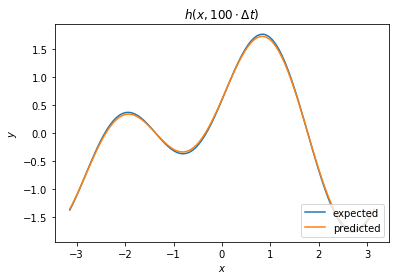

In [0]:
y_expected = h(x, dt*20)
y_predicted = w_test.copy()

plt.plot(x, y_expected, label="expected")
plt.plot(x, y_predicted, label="predicted")
plt.title("$h(x, 100\cdot\Delta t)$")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Okay, the prediction is kinda off but not *that* off

### Comparison to common schemes

In [0]:
def general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps,
                  boundary_condition="fixed", boundary_fixed_value=0):
  def move_up(u, i):
    return u[i] - dt/dx*(f(u[i]) - f(u[i-1]))
    
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
    elif boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
    else:
      u_next[0] = 0
    
    u_now = u_next.copy()
  return u_next

In [0]:
def lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps,
                         boundary_condition="fixed", boundary_fixed_value = 0):  
  def _next(j):
    return j+1 if j+1 < nx else 1
  
  def _prev(j):
    return j-1 if j-1 >= 0 else nx-2
  
  def move_up(u, i):
    return (1/4)*(u[_prev(i)] + 2*u[i] + u[_next(i)]) - \
           (dt/(2*dx))*(f(u[_next(i)]) - f(u[_prev(i)]))
    
  u_now  = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
      u_next[-1] = boundary_fixed_value
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
      u_next[-1] = move_up(u_now, -1)
    
    u_now = u_next.copy()
  return u_next

In [0]:
NT = 20

y_expected = test_func(x, dt*NT)
y_upwind = general_upwind_solver(test_func(x, 0), dt, dx, lambda u : u, nx, NT, boundary_condition="periodic")
y_lax = lax_friedrich_solver(test_func(x, 0), dt, dx, lambda u : u, nx, NT, boundary_condition="periodic")

y_nn = test_func(x, 0)
for _ in range(NT):
  y_nn = nn_solver.predict([generate_features(y_nn)]).flatten()

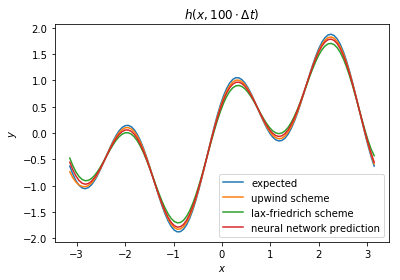

In [0]:
plt.plot(x, y_expected, label="expected")
plt.plot(x, y_upwind, label="upwind scheme")
plt.plot(x, y_lax, label="lax-friedrich scheme")
plt.plot(x, y_nn, label="neural network prediction")
plt.title("$h(x, 100\cdot\Delta t)$")
plt.legend(loc='lower right')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()